In [1]:
import pandas as pd
import numpy as np
import os as os
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import acessos as ac
import re
from pylift import TransformedOutcome
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
query = """

with base_principal as (
select distinct
--a.id_customer
a.cpf 
, case when tp_publico_experimento = 'Alvo' then 1 else 0 end as f_tratamento
, case when vl_total_spending_m0 > 0 then 1 else 0 end as f_conversao
, b.ds_persona
, b.ds_perfil_research
, b.ds_seg_consumo
, cr.ds_rfe_perfil_credito
, i.nr_score_ie 
, i.nr_score_ie_conta 
from  platform_analytics_zone.pmm_pool_ds_cartoes_experimentos_metricas a
left join customer_analytics_zone.ca_analitico_basao_crm b 
	on (a.cpf = b.cd_cpf)
left join customer_curated_zone.ca_model_rfe_credito cr 
	on (a.id_customer  = cr.id_customer and date_trunc('month', date_add('day', -1, a.dt_comunicacao)) = cr.dt_referencia)
left join platform_curated_zone.transaction_dedicada_spending s 
	on (a.cpf = s.cpf)
left join customer_curated_zone.ca_model_ie_cliente i 
	on (a.cpf = i.cd_cpf and to_date(concat(cast(i.cd_yearmonth as varchar), '01') , 'yyyymmdd') = date_trunc('month', date_add('day', -1, a.dt_comunicacao))) 
)
, com_aleatorizacao as (
select 
*, row_number() over (partition by f_tratamento, f_conversao order by rand()) as ordem
from base_principal
)
select * from com_aleatorizacao
where ordem <= 100000


"""

df = ac.df_athena('flavia-costa', query)

In [3]:
len(df)

400000

In [4]:
df.dtypes

cpf                       object
f_tratamento               int64
f_conversao                int64
ds_persona                object
ds_perfil_research        object
ds_seg_consumo            object
ds_rfe_perfil_credito     object
nr_score_ie              float64
nr_score_ie_conta        float64
ordem                      int64
dtype: object

In [5]:
df.head()

,cpf,f_tratamento,f_conversao,ds_persona,ds_perfil_research,ds_seg_consumo,ds_rfe_perfil_credito,nr_score_ie,nr_score_ie_conta,ordem
0,13701151644,0,0,"29 - Mulher, Até 24 anos, Sudeste e Sul",Multiplicador / Barrado no Crédito,None,None,0.000000,0.000000,1
1,14540696602,0,0,"8 - Mulher, Solteira, Até 24 anos, cidade Pequ...",NI,SAUDE - 5,None,28.474576,0.000000,2
2,07099639390,0,0,"16 - Homem, 25 a 40 anos, Nordeste",Acumulador,None,None,0.000000,0.000000,3
3,48342456838,0,0,"20 - Homem, Até 24 anos, Sudeste e Sul",Multiplicador,VIAGEM - 5,None,36.827466,28.205128,4
4,07149270581,0,0,"26 - Homem, Até 24 anos, Nordeste",Multiplicador,None,None,0.000000,0.000000,5


In [6]:
df.isnull().sum()

cpf                           0
f_tratamento                  0
f_conversao                   0
ds_persona                 2994
ds_perfil_research        11392
ds_seg_consumo           181379
ds_rfe_perfil_credito    392295
nr_score_ie                 328
nr_score_ie_conta           328
ordem                         0
dtype: int64

In [7]:
id_columns = ['cpf', 'ordem']
cat_columns = df.drop(id_columns, axis = 1).select_dtypes('object').columns
num_columns = df.drop(id_columns, axis = 1).select_dtypes(exclude=['object']).columns

In [8]:
df.drop(id_columns, axis=1).describe()

,f_tratamento,f_conversao,nr_score_ie,nr_score_ie_conta
count,400000.000000,400000.000000,399672.000000,399672.000000
mean,0.500000,0.500000,47.016988,33.861712
std,0.500001,0.500001,30.916703,32.901033
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,7.036071,0.000000
50%,0.500000,0.500000,58.083442,29.487179
75%,1.000000,1.000000,71.786180,62.820513
max,1.000000,1.000000,99.743590,100.000000


In [9]:
df['f_conversao'].value_counts()

0    200000
1    200000
Name: f_conversao, dtype: int64

In [10]:
pd.crosstab(df.f_conversao, df.f_tratamento)

f_tratamento,0,1
f_conversao,,
0,100000,100000
1,100000,100000


In [11]:
for column in df.columns:
  if df[column].dtype == 'object':
    df[column].fillna(df[column].mode()[0], inplace = True)
  elif df[column].dtype == 'string':
    df[column].fillna(df[column].mode()[0], inplace = True)
  elif df[column].dtype != 'object':
    df[column].fillna(df[column].median(), inplace = True)

In [12]:
df.isnull().sum()

cpf                      0
f_tratamento             0
f_conversao              0
ds_persona               0
ds_perfil_research       0
ds_seg_consumo           0
ds_rfe_perfil_credito    0
nr_score_ie              0
nr_score_ie_conta        0
ordem                    0
dtype: int64

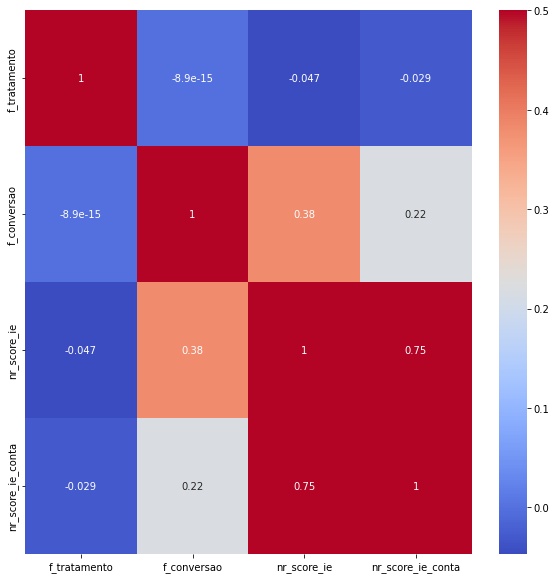

In [13]:
import seaborn as sns
plt.figure(figsize=(10,10))
sns.heatmap(df.drop(id_columns, axis=1).corr(), annot=True, cmap="coolwarm", vmax=0.5)
plt.show()

In [14]:
from sklearn.ensemble import RandomForestClassifier

In [15]:
df_model = pd.get_dummies(df, columns=cat_columns)

In [18]:
nao_preditor = ['cpf','ordem' , 'f_conversao']
target = ['f_conversao']

preditores = df_model.drop(nao_preditor, axis = 1).columns

In [19]:
df_model.isnull().sum()

cpf                                                                         0
f_tratamento                                                                0
f_conversao                                                                 0
nr_score_ie                                                                 0
nr_score_ie_conta                                                           0
                                                                           ..
ds_rfe_perfil_credito_05-Cliente maduro - Entrante ascensao                 0
ds_rfe_perfil_credito_06-Cliente maduro - Onliners medio - desaceleracao    0
ds_rfe_perfil_credito_07-Cliente maduro - Onliners medio - estavel          0
ds_rfe_perfil_credito_08-Cliente maduro - Super Onliners - desaceleracao    0
ds_rfe_perfil_credito_09-Cliente maduro - Super Onliners - estavel          0
Length: 157, dtype: int64

In [20]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
import lightgbm as lgb
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier


In [21]:
x_train, x_test, y_train, y_test = train_test_split(df_model[preditores]
                                                    , df_model[target]
                                                    , random_state=42, test_size=0.20)

In [22]:
x_train = x_train.replace([np.inf, -np.inf], 0)
x_test = x_test.replace([np.inf, -np.inf], 0)

In [23]:
x_test_sim = x_test.copy()

x_test_sim['f_tratamento'] = 0

In [24]:
x_test_sim['f_tratamento'].sum()

0

In [25]:
x_test['f_tratamento'].sum()

40104

In [26]:
clf = RandomForestClassifier(n_estimators=400)
clf.fit(x_train, y_train)


/tmp/ipykernel_445923/2067407183.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train, y_train)


RandomForestClassifier(n_estimators=400)

In [27]:
y_predicted_clf = clf.predict(x_test)
print(metrics.accuracy_score(y_test, y_predicted_clf).round(4))

0.6597


In [28]:
clf_results = pd.DataFrame()
clf_results['predito'] = y_predicted_clf
clf_results['real'] = y_test.values

df_confusion = pd.crosstab(clf_results.real, clf_results.predito)
df_confusion.head()

predito,0,1
real,,
0,25707,14138
1,13089,27066


<AxesSubplot:>

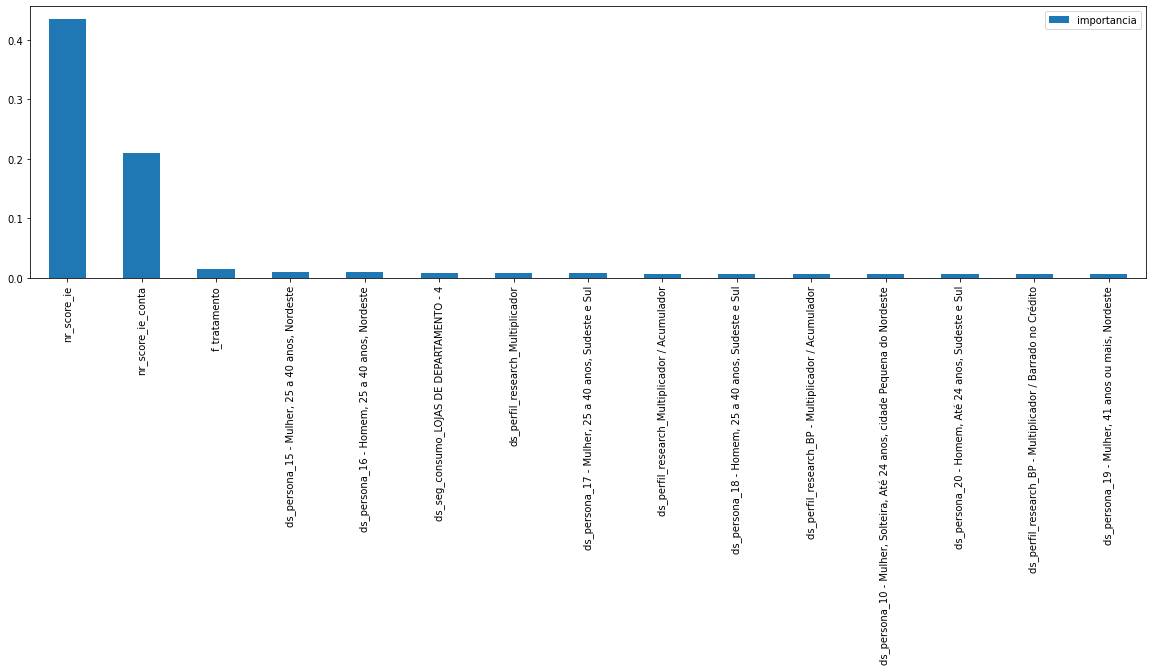

In [29]:
importance_df = pd.DataFrame(clf.feature_importances_, columns = ['importancia'], index = preditores)
importance_df.sort_values(by='importancia', ascending=False).head(15).plot.bar(figsize=(20,5))

In [30]:
y_predicted_clf_proba = clf.predict_proba(x_test)[:, 1]

clf_results['Probabilidade'] = y_predicted_clf_proba
clf_results['fx_score'] = np.round(clf_results['Probabilidade'], 1)
clf_results['cpf'] =  1

clf_results_agg = clf_results.groupby('fx_score').agg({'real': ['count', 'sum']})
clf_results_agg.columns = clf_results_agg.columns.droplevel(0)
clf_results_agg['taxa_evento'] = clf_results_agg['sum'] / clf_results_agg['count']
clf_results_agg

,count,sum,taxa_evento
fx_score,,,
0.0,4063,340,0.083682
0.1,7124,1311,0.184026
0.2,8951,2762,0.308569
0.3,8053,3340,0.414752
0.4,6927,3255,0.469900
0.5,7826,4480,0.572451
0.6,8430,5286,0.627046
0.7,9446,6196,0.655939
0.8,9334,6409,0.686630


In [31]:
y_predicted_proba_sim = clf.predict_proba(x_test_sim)[:, 1]

In [32]:
df_analise = x_test.copy()
len(df_analise)

80000

In [33]:
df_analise['prediction_actual'] = y_predicted_clf_proba
df_analise['prediction_sim'] = y_predicted_proba_sim

In [34]:
df_analise['ate'] = df_analise['prediction_actual'] - df_analise['prediction_sim']

<AxesSubplot:xlabel='ate', ylabel='Count'>

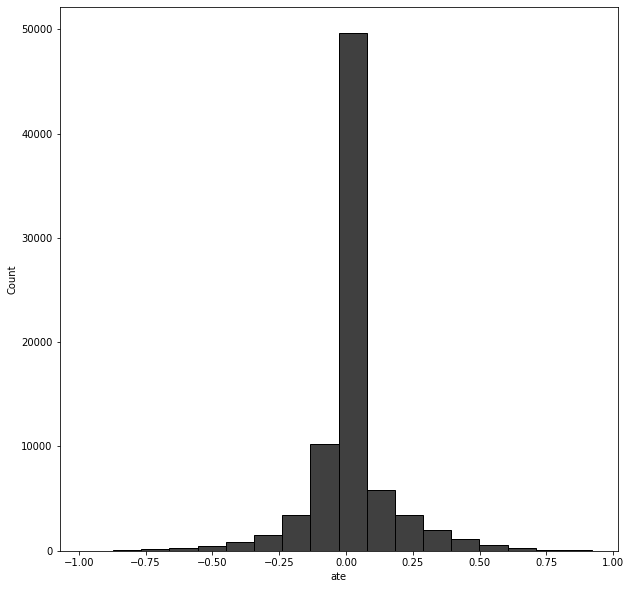

In [35]:
plt.figure(figsize=(10,10))
sns.histplot(data = df_analise, x = 'ate', color = "black")

In [36]:
df_analise['ate'].describe()

count    80000.000000
mean         0.009780
std          0.153055
min         -0.977208
25%          0.000000
50%          0.000000
75%          0.000000
max          0.921530
Name: ate, dtype: float64

In [37]:
df_analise['fx_ate'] = np.where((df_analise['ate'] < 0), "Conversão piora com Campanha",
                    np.where((df_analise['ate'] == 0) , "Campanha Indiferente", 
                    np.where((df_analise['ate'] > 0) & (df_analise['ate'] <= 0.25), "Leve melhora com a campanha",
                    "Melhora muito com campanha")))

df_analise['fx_ate'].value_counts()

Campanha Indiferente            40195
Conversão piora com Campanha    19822
Leve melhora com a campanha     14835
Melhora muito com campanha       5148
Name: fx_ate, dtype: int64

In [38]:
df_analise[['fx_ate', 'ate']].groupby('fx_ate').mean()

,ate
fx_ate,
Campanha Indiferente,0.000000
Conversão piora com Campanha,-0.139705
Leve melhora com a campanha,0.100884
Melhora muito com campanha,0.399188


In [39]:
df_analise[['prediction_actual', 'fx_ate']].groupby('fx_ate').mean()

,prediction_actual
fx_ate,
Campanha Indiferente,0.496815
Conversão piora com Campanha,0.355344
Leve melhora com a campanha,0.598057
Melhora muito com campanha,0.774129


<AxesSubplot:xlabel='ate', ylabel='prediction_actual'>

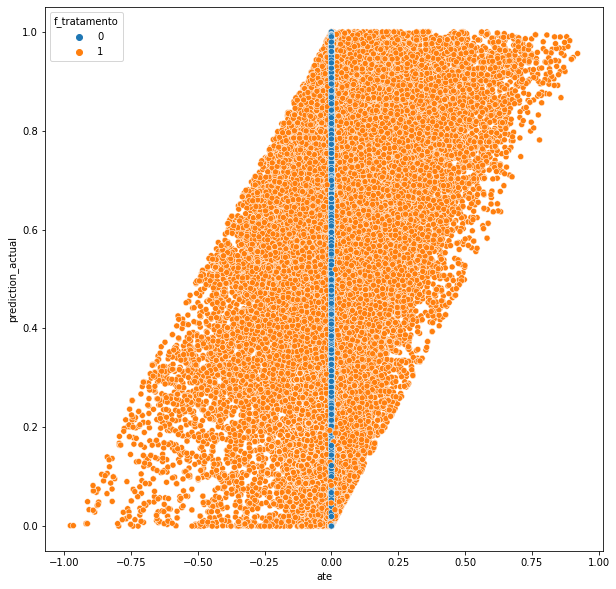

In [40]:
plt.figure(figsize=(10,10))
sns.scatterplot(data = df_analise, y = 'prediction_actual', x = 'ate', hue = 'f_tratamento')

In [41]:
df_analise = df_analise.join(df['cpf'])

In [42]:
df_analise

,f_tratamento,nr_score_ie,nr_score_ie_conta,"ds_persona_0 - Mulher, Casada, 25 anos ou mais, cidade Pequena do Nordeste","ds_persona_1 - Mulher, Solteira, Até 24 anos, cidade Média do Sudeste ou Sul","ds_persona_10 - Mulher, Solteira, Até 24 anos, cidade Pequena do Nordeste","ds_persona_11 - Homem, Solteiro, Até 24 anos, cidade Pequena do Nordeste","ds_persona_12 - Mulher, Solteira, 35 anos ou mais, cidade Pequena do Nordeste, ensino fundamental cursando ou completo","ds_persona_13 - Homem, Solteiro, 35 anos ou mais, cidade Média do Norte ou Centro-Oeste","ds_persona_14 - Homem, Casado, 35 anos ou mais, cidade Pequena do Nordeste",...,ds_rfe_perfil_credito_05-Cliente maduro - Entrante ascensao,ds_rfe_perfil_credito_06-Cliente maduro - Onliners medio - desaceleracao,ds_rfe_perfil_credito_07-Cliente maduro - Onliners medio - estavel,ds_rfe_perfil_credito_08-Cliente maduro - Super Onliners - desaceleracao,ds_rfe_perfil_credito_09-Cliente maduro - Super Onliners - estavel,prediction_actual,prediction_sim,ate,fx_ate,cpf
23218,0,0.000000,0.000000,0,0,0,0,0,0,0,...,0,0,1,0,0,0.146613,0.146613,0.000000,Campanha Indiferente,53252411172
20731,0,75.341156,51.282051,0,0,0,0,0,0,0,...,0,0,1,0,0,0.963125,0.963125,0.000000,Campanha Indiferente,70639494463
39555,0,63.724468,47.435897,0,0,1,0,0,0,0,...,0,0,1,0,0,0.793500,0.793500,0.000000,Campanha Indiferente,50977658856
147506,0,55.076054,44.871795,0,0,0,0,0,0,0,...,0,0,1,0,0,0.101667,0.101667,0.000000,Campanha Indiferente,13998847430
314215,0,0.000000,0.000000,0,0,0,0,0,0,0,...,0,0,1,0,0,0.183399,0.183399,0.000000,Campanha Indiferente,59716967187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54840,0,62.772708,35.897436,0,0,0,0,0,0,0,...,0,0,1,0,0,0.754583,0.754583,0.000000,Campanha Indiferente,07780955508
103,0,72.590178,78.205128,0,0,0,0,0,0,1,...,0,0,1,0,0,0.783542,0.783542,0.000000,Campanha Indiferente,00853711305
339434,0,0.000000,0.000000,0,0,0,0,0,0,0,...,0,0,1,0,0,0.699571,0.699571,0.000000,Campanha Indiferente,02179896166
315677,0,71.234246,78.205128,0,0,0,0,0,0,0,...,0,0,1,0,0,0.510757,0.510757,0.000000,Campanha Indiferente,10061656496


In [43]:
df_analise.dtypes

f_tratamento                                                                      int64
nr_score_ie                                                                     float64
nr_score_ie_conta                                                               float64
ds_persona_0 - Mulher, Casada, 25 anos ou mais, cidade Pequena do Nordeste        uint8
ds_persona_1 - Mulher, Solteira, Até 24 anos, cidade Média do Sudeste ou Sul      uint8
                                                                                 ...   
prediction_actual                                                               float64
prediction_sim                                                                  float64
ate                                                                             float64
fx_ate                                                                           object
cpf                                                                              object
Length: 159, dtype: object

In [45]:
df_analise[['cpf', 'fx_ate']].to_csv('teste_polis.csv', index = False)

### Conclusões

Uplift / 
Converte mais se fizer parte do grupo tratamento:

- Multiplicador puro ou Multiplicador / Acumulador
- IE excluindo a primeira faixa (p75 ou acima)
- 04-Cliente maduro - Entrante estavel OU 07-Cliente maduro - Onliners medio - estavel
- EDUCACAO - 4 OU DELIVERY - 1 OU PET - 5 OU SUPERMERCADO - 6 OU PET - 3
- Para mulheres também vemos uma tendencia a melhorar a conversão com as campanhas


Ou seja, os demais clientes já possuem uma conversão natural ou são casos perdidos. Mais comunicações deveriam ser considerados para esses grupos.

## A investigar:

- Tamanho da cidade
- Localização
- Outras afinidades de produto